In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import sklearn
pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_csv('/content/Churn_Modelling.csv').drop(columns = ['Surname', 'RowNumber'])

In [ ]:
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(data, test_size = 0.2, random_state = 2022)

In [ ]:
## separating the categorical features and numerical features
num_cols = list(set(train_data.describe().columns.to_list()) - set(['CustomerId']))
cat_cols = list(set(train_data.columns.to_list()) - set(num_cols) - set(['CustomerId']))

# visuals

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f688d862290>,
      dtype=object)

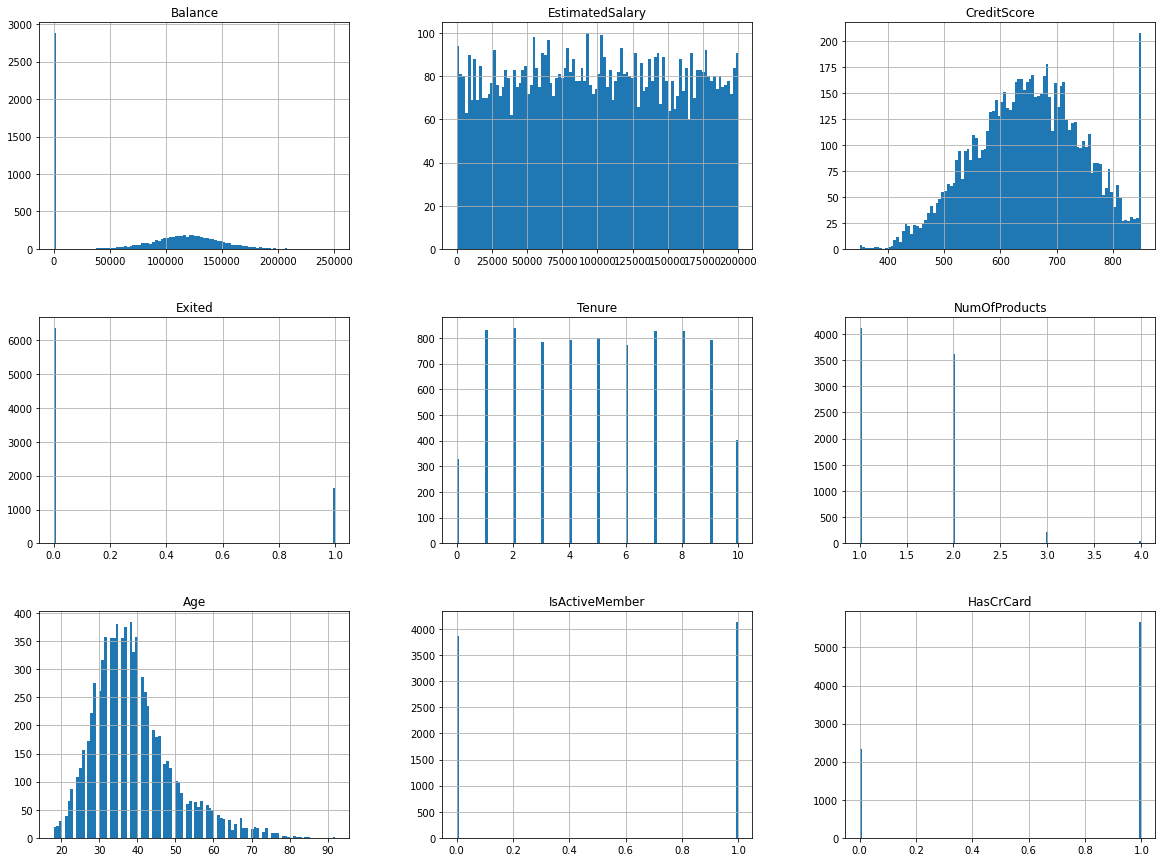

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
train_data[num_cols].hist(bins = 100, figsize = (20, 15))

In [ ]:
#making dataframes each of them contains the categories of a catgegorical variable and theire frequencies
df_list=[]
for cat_column in cat_cols:
    df_list.append(train_data.groupby([cat_column])['CustomerId'].count().reset_index().rename(columns = {'CustomerId' : 'count'}))

In [ ]:
len(df_list)

2

In [ ]:
cat_cols

['Geography', 'Gender']

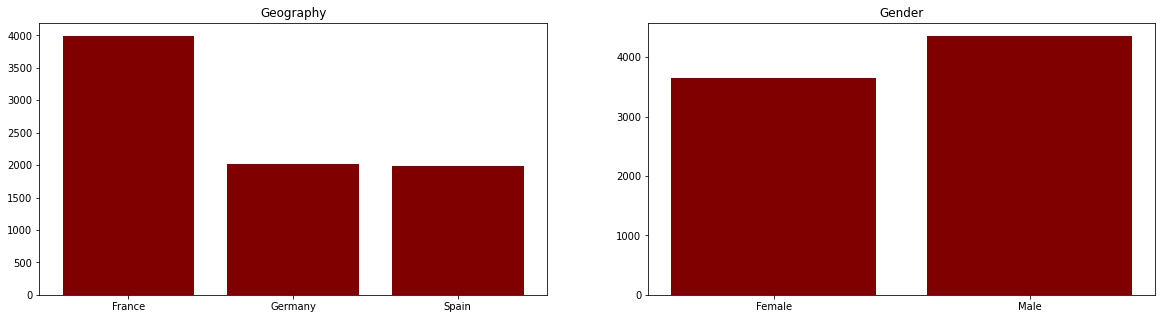

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
i=0
j=0
for df in df_list[0:10]:
    axes[j].bar(df.iloc[:, 0],df.iloc[:, 1], color ='maroon')
    axes[j].set_title(df.columns[0])
    if(j<1):
        j+=1
plt.show()

# Data Preprocessing

### Handeling Nulls

In [ ]:
data.isna().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Handling skewness and outliers

In [ ]:
## separating the categorical features and numerical features
num_cols = list(set(train_data.describe().columns.to_list()) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))
cat_cols = list(set(train_data.columns.to_list()) - set(num_cols) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))

In [ ]:
def bounds_calc(df, col):
  Q1 = np.percentile(train_data[col], q = 25, interpolation = 'midpoint')
  Q3 = np.percentile(train_data[col], q = 75, interpolation = 'midpoint')
  IQR = Q3 - Q1
  Upper_Bound = Q3 + 5*IQR
  Lower_Bound = Q1 - 5*IQR
  return Lower_Bound, Upper_Bound

def outliers_clamping(Lower_Bound, Upper_Bound, value):
  if value > Upper_Bound:
    return Upper_Bound
  elif value < Lower_Bound:
    return Lower_Bound
  else:
    return value

def skewness_calc(col ,df):
    std_col = np.std(df[col])
    mean_col = np.mean(df[col])
    size_rows = df.count()[0]
    df['diff_col'] = df[col] - mean_col
    df['diff_col_powered'] = np.power(df['diff_col'], 3)
    skewness = np.sum(df['diff_col_powered'])/((size_rows - 1) * np.power(std_col, 3))
    df.drop(columns = ['diff_col_powered', 'diff_col'], inplace = True)
    return skewness

def skewed_data_transformation(value):
  return np.log(1 + np.abs(value))

In [ ]:
# outliers handling
for col in num_cols:
  Lower_Bound, Upper_Bound = bounds_calc(train_data, col)
  train_data[col] = train_data[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))
  validation_data[col] = validation_data[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))

In [ ]:
# skewness handling
skewed_cols = []
for col in num_cols: 
  sk = skewness_calc(col, train_data)
  if (np.abs(sk) >= 1):
    skewed_cols.append(col)
    train_data[col] = train_data[col].apply(lambda x : skewed_data_transformation(x))
    validation_data[col] = validation_data[col].apply(lambda x : skewed_data_transformation(x))

In [ ]:
skewed_cols

['Age']

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 5516 to 4989
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       8000 non-null   int64  
 1   CreditScore      8000 non-null   int64  
 2   Geography        8000 non-null   object 
 3   Gender           8000 non-null   object 
 4   Age              8000 non-null   float64
 5   Tenure           8000 non-null   int64  
 6   Balance          8000 non-null   float64
 7   NumOfProducts    8000 non-null   int64  
 8   HasCrCard        8000 non-null   int64  
 9   IsActiveMember   8000 non-null   int64  
 10  EstimatedSalary  8000 non-null   float64
 11  Exited           8000 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 812.5+ KB


In [ ]:
train_data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,1.569113e+07,650.897750,3.654376,5.028875,76696.045283,1.524500,0.708250,0.516750,99988.568160,0.203000
std,7.175830e+04,96.566583,0.252560,2.899800,62380.930567,0.582831,0.454596,0.499751,57388.439998,0.402258
min,1.556570e+07,350.000000,2.944439,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.562882e+07,584.000000,3.496508,2.750000,0.000000,1.000000,0.000000,0.000000,51446.617500,0.000000
50%,1.569189e+07,652.000000,3.637586,5.000000,97405.605000,1.000000,1.000000,1.000000,99812.150000,0.000000
75%,1.575292e+07,718.000000,3.806662,8.000000,127652.345000,2.000000,1.000000,1.000000,148955.820000,0.000000
max,1.581569e+07,850.000000,4.532599,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


### checking if the variable is normally distributed

In [ ]:
## separating the categorical features and numerical features
num_cols = list(set(train_data.describe().columns.to_list()) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))
cat_cols = list(set(train_data.columns.to_list()) - set(num_cols) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))

#### qq plot

In [ ]:
len(num_cols)

6

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


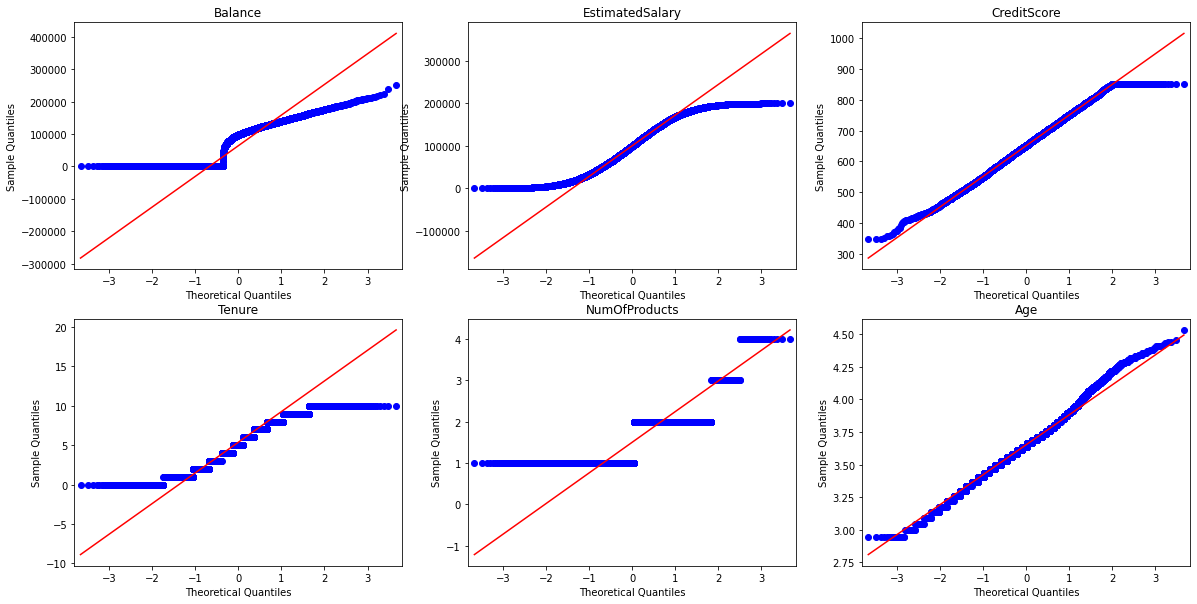

In [ ]:
import statsmodels.api as sm
ncols = 3
nrows=2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20, 10))
i=0
j=0
for col in num_cols:
    sm.qqplot(train_data[col],fit = False, line='q', ax = axes[i, j])
    axes[i, j].set_title(col)
    if(j<ncols-1):
        j+=1
    else:
        i+=1
        j=0
plt.show()

In [ ]:
""" Testing the normally distributed features using Shapiro-Wilk test
 the null hypothesis here is that the data follows a normal distribution
 we reject the null hypothesis (aka: data is not normally distributed) if the p-value is less than alpha (typically 5%)
 and we fail to reject the null hypothesis (aka: data is normally distributes) if the p-value is greater than alpha """
feats_std_scale = []
feats_min_max_scale = []
sample_data  = train_data.sample(replace = False, n= 500)

from scipy.stats import shapiro
for col in num_cols:
    stat, p = shapiro(sample_data[col])
    print('W_Statistic=%.3f, p=%.8f' % (stat, p))

    alpha = 0.001
    if p > alpha:
        print(f'{col} looks like gaussian (fail to reject H0)')
        feats_std_scale.append(col)
    else:
        print(f'{col} does not look Gaussian (reject H0)')
        feats_min_max_scale.append(col)

W_Statistic=0.845, p=0.00000000
Balance does not look Gaussian (reject H0)
W_Statistic=0.952, p=0.00000000
EstimatedSalary does not look Gaussian (reject H0)
W_Statistic=0.992, p=0.00849733
CreditScore looks like gaussian (fail to reject H0)
W_Statistic=0.942, p=0.00000000
Tenure does not look Gaussian (reject H0)
W_Statistic=0.703, p=0.00000000
NumOfProducts does not look Gaussian (reject H0)
W_Statistic=0.993, p=0.02250508
Age looks like gaussian (fail to reject H0)


### min-max scale and standardize

In [ ]:
feats_min_max_scale

['Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

In [ ]:
feats_std_scale

['CreditScore', 'Age']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
# fitting
min_max_scaler_model = min_max_scaler.fit(train_data[feats_min_max_scale])
std_scaler_model = std_scaler.fit(train_data[feats_std_scale])
# transforming min_max_scale
min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(train_data[feats_min_max_scale]), columns = feats_min_max_scale)
min_max_scaled_test_data = pd.DataFrame(min_max_scaler_model.transform(validation_data[feats_min_max_scale]), columns = feats_min_max_scale)

# tranforming std_scale
std_scaled_train_data =pd.DataFrame( std_scaler_model.transform(train_data[feats_std_scale]), columns = feats_std_scale)
std_scaled_test_data =pd.DataFrame( std_scaler_model.transform(validation_data[feats_std_scale]), columns = feats_std_scale)

In [ ]:
cat_cols

['Gender', 'Geography']

In [ ]:
# label encoding of the Gender
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_enc_model = LabelEncoder().fit(train_data['Gender'])
train_data['Gender'] = label_enc_model.transform(train_data['Gender'])
validation_data['Gender'] = label_enc_model.transform(validation_data['Gender'])

one_hot_enc_model = OneHotEncoder(sparse = False).fit(train_data[['Geography']])
ohe_train_data = one_hot_enc_model.transform(train_data[['Geography']])
ohe_test_data = one_hot_enc_model.transform(validation_data[['Geography']])

a=one_hot_enc_model.categories_
col_names=[]
for list_ in a:
    for element in list_:
        col_names.append(element)

nominal_train_df = pd.DataFrame(ohe_train_data, columns = col_names)
nominal_test_df = pd.DataFrame(ohe_test_data, columns = col_names)

In [ ]:
nominal_train_df = nominal_train_df.merge(train_data[['Gender']], right_index = True, left_index = True)
nominal_test_df = nominal_test_df.merge(validation_data[['Gender']], right_index = True, left_index = True)

In [ ]:
num_train_df = std_scaled_train_data.merge(min_max_scaled_train_data, right_index = True, left_index = True)\
                  .merge(train_data[['HasCrCard', 'Exited', 'IsActiveMember']], right_index = True, left_index = True)

num_test_df = std_scaled_test_data.merge(min_max_scaled_test_data, right_index = True, left_index = True)\
                  .merge(validation_data[['HasCrCard', 'Exited', 'IsActiveMember']], right_index = True, left_index = True)

In [ ]:
final_train_data = nominal_train_df.merge(num_train_df, right_index = True, left_index = True, how = 'inner')

final_test_data = nominal_test_df.merge(num_test_df, right_index = True, left_index = True, how = 'inner')

### Solving the problem of imbalance

In [ ]:
len(final_train_data[final_train_data['Exited'] == 1])/ len(final_train_data)

0.20471212357622093

In [ ]:
rare_class_data = final_train_data[final_train_data['Exited'] == 1]
dominant_class_data = final_train_data[final_train_data['Exited'] == 0]

under_sampled_class = dominant_class_data.sample(frac = 0.25, replace = False, random_state = 2022)
train_undersampled = pd.concat((under_sampled_class, rare_class_data), axis = 0)

In [ ]:
# final_train_data, final_test_data
train_x = train_undersampled.drop(columns =['Exited'])
train_y = train_undersampled[['Exited']]

val_x = train_undersampled.drop(columns =['Exited'])
val_y = train_undersampled[['Exited']]

# Logistic Regression

#### Logistic regression from scratch

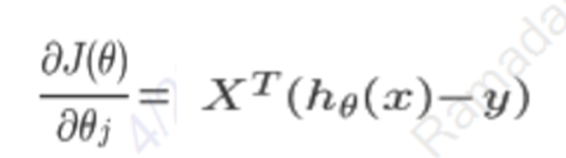

In [ ]:
def initialize(X, bias = True):
  if bias:
    weights = np.zeros((X.shape[1]+1,1))
    X = np.c_[np.ones((X.shape[0],1)),X]
  else:
    weights = np.zeros((X.shape[1],1))
  return weights,X

def sigmoid(z):
  sig = 1/(1 + np.e**(-z))
  return sig

def cost(X, y, theta):
  z = np.dot(X,theta)
  cost0 = y.T.dot(np.log(sigmoid(z)))
  cost1 = (1-y).T.dot(np.log(1-sigmoid(z)))
  cost = -((cost1 + cost0))/len(y) 
  return cost

def fit(X, y, lr=0.001, bias = True, max_iterations=100):
  params,X = initialize(X, bias)
  for i in range(max_iterations):
      params = params - lr * np.dot(X.T, sigmoid(np.dot(X,params)) - np.reshape(y,(len(y),1)))
  return params

def predict(X, optimum_weights, bias = True, threshold = 0.5):
  z = np.dot(initialize(X, bias)[1], optimum_weights)
  preds = []
  for i in sigmoid(z):
      if i>threshold:
          preds.append(1)
      else:
          preds.append(0)
  return preds

In [ ]:
train_x.shape

(6409, 12)

In [ ]:
train_y.shape

(6409,)

In [ ]:
bias = True
max_iterations = 100
lr = 0.001
optimum_weights = fit(train_x, train_y, lr = 0.001, bias = bias, max_iterations = max_iterations)

In [ ]:
test_preds = predict(val_x, optimum_weights, bias = bias, threshold = 0.47)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_preds, val_y)

0.6117556071152359

#### Comparing our results with sklearn logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter= max_iterations, fit_intercept= bias).fit(train_x, train_y)

y_pred_sklearn = model.predict(val_x)

accuracy_score(y_pred_sklearn, val_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6067285382830626

#### Evaluating the performance of the model

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(val_y, test_preds).T).rename(columns = {0 : 'actual_not_churn', 1: 'actual_churn'})
conf_matrix

,actual_not_churn,actual_churn
0,650,380
1,624,932


In [ ]:
people_predicted_not_churn = conf_matrix.iloc[0, :].sum()
people_predicted_churn = conf_matrix.iloc[1, :].sum()

people_who_actually_not_churned = conf_matrix.sum()[0]
people_who_actually_churned = conf_matrix.sum()[1]

precision_not_churn = conf_matrix.iloc[0, 0]/people_predicted_not_churn
precision_churn = conf_matrix.iloc[1, 1]/people_predicted_churn

recall_not_churn = conf_matrix.iloc[0, 0]/people_who_actually_not_churned
recall_churn = conf_matrix.iloc[1, 1]/people_who_actually_churned

F1_score_not_churn = 2 * ((precision_not_churn * recall_not_churn)/(precision_not_churn + recall_not_churn))
F1_score_churn = 2 * ((precision_churn * recall_churn)/(precision_churn + recall_churn))

In [ ]:
print('precision_not_churn: ', precision_not_churn)
print('precision_churn: ', precision_churn)
print('recall_not_churn: ', recall_not_churn)
print('recall_churn: ', recall_churn)
print('F1_score_not_churn: ', F1_score_not_churn)
print('F1_score_churn: ', F1_score_churn)

precision_not_churn:  0.6310679611650486
precision_churn:  0.5989717223650386
recall_not_churn:  0.5102040816326531
recall_churn:  0.7103658536585366
F1_score_not_churn:  0.564236111111111
F1_score_churn:  0.6499302649930264


In [ ]:
list_of_preds_churn = [1000]
true_positives = [300]
actual_churners = [400]

captured = 300/400 churners (75% of the churners i succeeded to identify them)

lose_money = [1000 people] only 300 will be actual churners

#proposed by the business owner
list_ = [500]
true_positives = 200 
recall = 50%
recall = 100% (no opportunity loss)
# no problem with the size of the list (5000)

#### ROC Curve

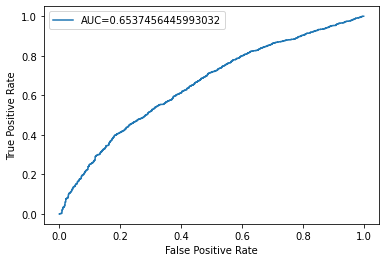

In [ ]:
from sklearn import metrics
y_pred_proba = model.predict_proba(val_x)[::, 1]

fpr, tpr, thresholds = metrics.roc_curve(val_y, y_pred_proba)

auc = metrics.roc_auc_score(val_y, y_pred_proba)

#create ROC curve showing in the bottom the AUC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=2)
plt.show()

In [ ]:
# recall >= 70%
np.where(tpr >= 0.7)
thresholds[699]

0.474220781701939

In [ ]:
thresholds

array([1.74104046, 0.74104046, 0.73408404, ..., 0.24907102, 0.2474651 ,
       0.23840623])

In [ ]:
fpr

array([0.        , 0.        , 0.00313972, ..., 0.99686028, 0.99686028,
       1.        ])

In [ ]:
tpr

array([0.00000000e+00, 7.62195122e-04, 7.62195122e-04, ...,
       9.99237805e-01, 1.00000000e+00, 1.00000000e+00])